In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from scipy.special import factorial
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.distributions import *
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt
from torchdeepretina.pyret_func import estfr
import pyret

In [62]:
file_path = '/home/xhding/tem_stim/21-03-15/naturalscene.h5'
cells = [0,1,2,3,4,6]
t_list = [3,3,3,3,2,3]
recording = recording_stats(file_path, cells)
recording_cut = recording_stats(file_path, cells, truncate=True, t_list=t_list)
single_trial_bin = recording.single_trial_bin
single_trial_bin_cut = recording_cut.single_trial_bin

In [5]:
device = torch.device('cuda:6')
cfg = get_custom_cfg('bn_cnn_stack_try')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_070_loss_-3.54_pearson_0.6845.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
test_data = DataLoader(TestDataset(cfg), batch_size=10000)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 6, device, cfg)

In [9]:
binomial_para = [2.17, 2.85, 2.5, 2.5, 1.0, 0.47]

pred_single_trial = model_single_trial(model, test_data, device, t_list, binomial_para, pred, recording, gaussian=[0, 0, 0.3, 0], seed1=39, seed2=39)

In [13]:
error(single_trial_bin, pred_single_trial)

(0.9001502607156162, 0.6435970301675193, 0.2565532305480969)

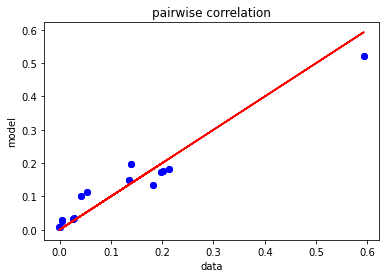

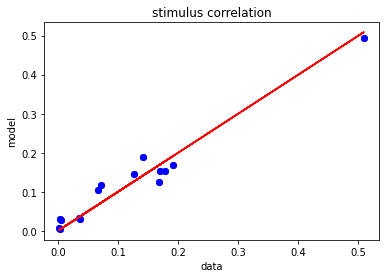

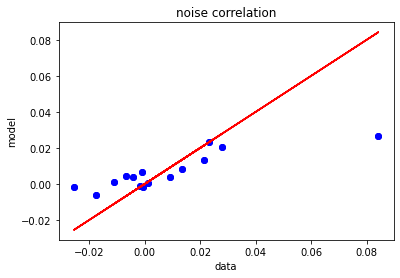

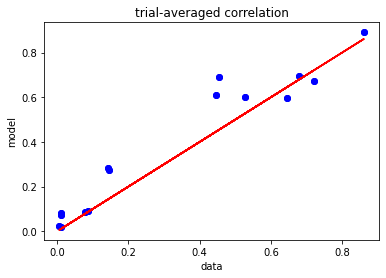

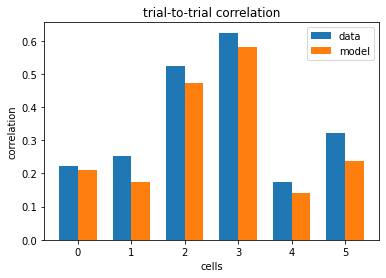

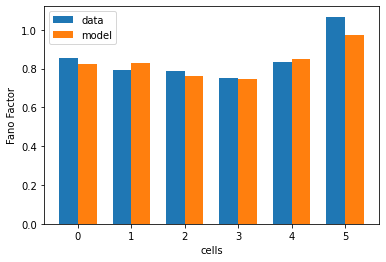

In [14]:
correlation_plot(single_trial_bin, pred_single_trial)

In [78]:
optimum_para = {}
optimum_para['gaussian'] = [0.61, 0.56, 0.56, 0.58, 1., 1.22]
optimum_para['poisson1'] = [5.56, 8.87, 4.65, 3.80, 1., 0.83]
optimum_para['poisson2'] = [3.81, 5.03, 3.30, 2.92, 6.10, 0.61]
optimum_para['binomial'] = [2.17, 2.85, 1.91, 1.69, 1., 0.47]

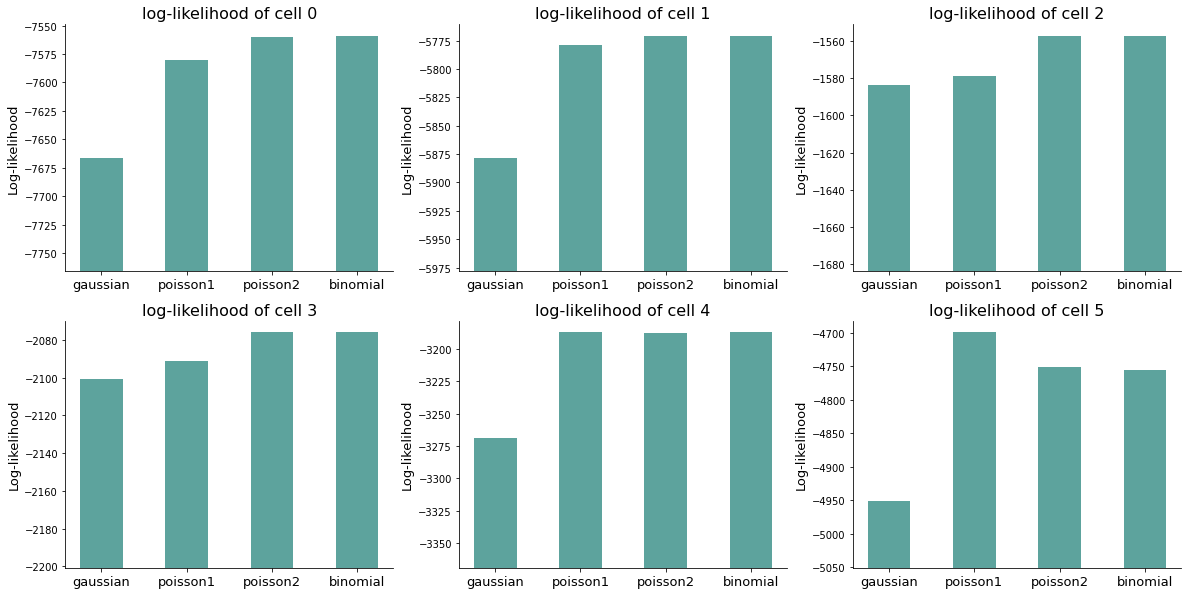

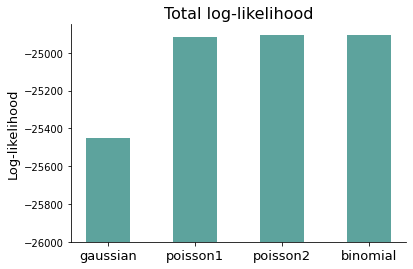

In [80]:
lls = log_likelihood(recording_cut, t_list, optimum_para)
log_likelihood_plot(lls)
log_likelihood_plot(lls, mean=True)

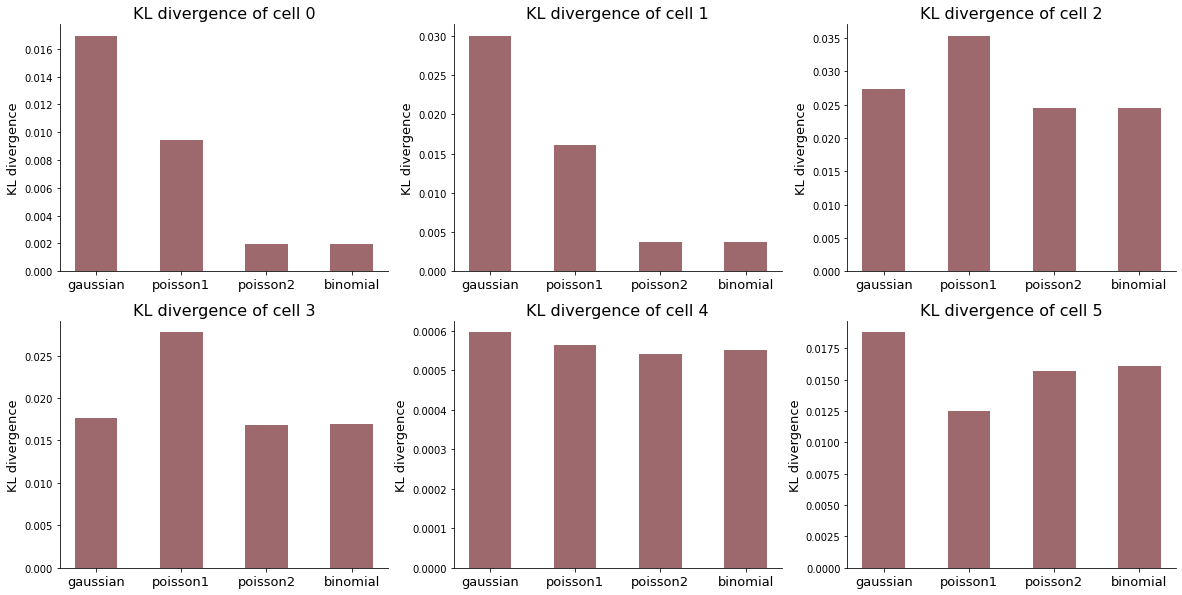

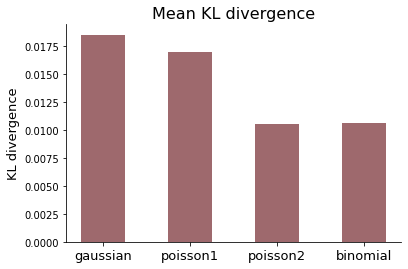

In [79]:
kls = kullback_leibler(recording_cut, t_list, optimum_para)
kullback_leibler_plot(kls)
kullback_leibler_plot(kls, mean=True)

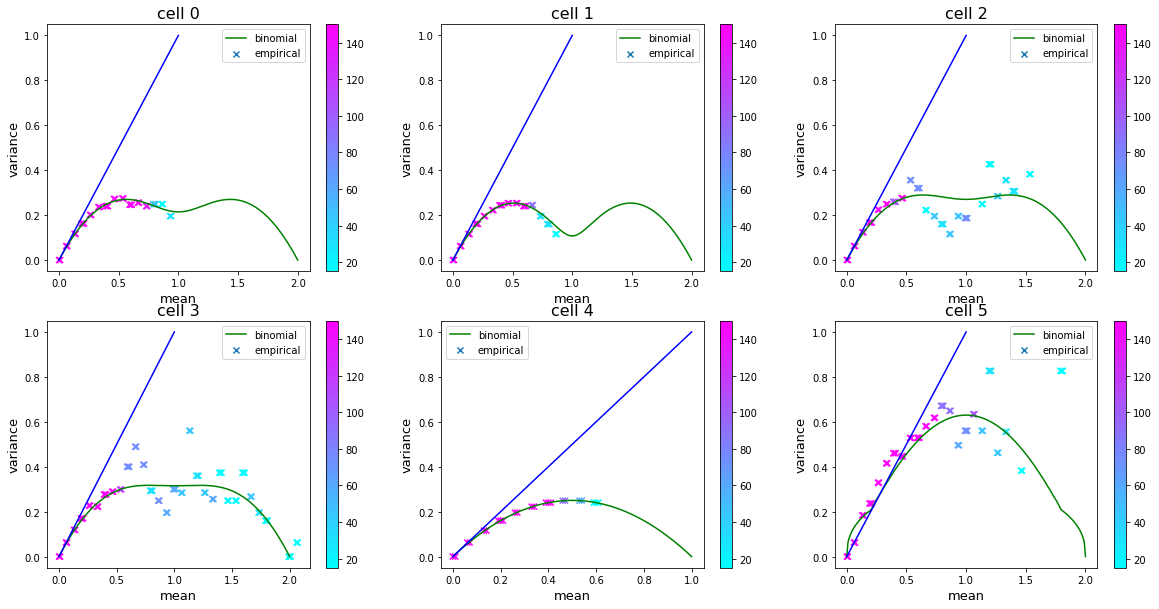

In [61]:
variance_mean_plot(recording, t_list, optimum_para)